In [141]:
import pandas as pd
import numpy as np
import warnings
import numpy.typing as npt
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import seaborn as sns
import json

warnings.filterwarnings("ignore")

In [142]:
# constants

TEST_SIZE: np.float16 = 0.3
CROSS_VALIDATION_K: np.int8 = 5
RANDOM_STATE: np.int8 = 42
SQUARE_VALUES: list[str] = ["x", "o", "b"]

In [143]:
COLUMNS: list[str] = ["tl", "tm", "tr", "ml", "mm", "mr", "bl", "bm", "br", "class"]

# ttt is a acronym for tic tac toe
ttt_df: pd.DataFrame = pd.read_csv(
    "../data/tictactoe/tic-tac-toe.data", header=None, names=COLUMNS
)
ttt_df["class"] = ttt_df["class"] == "positive"
ttt_df.rename(columns={"class": "positive"}, inplace=True)
ttt_df.head(5)

,tl,tm,tr,ml,mm,mr,bl,bm,br,positive
0,x,x,x,x,o,o,x,o,o,True
1,x,x,x,x,o,o,o,x,o,True
2,x,x,x,x,o,o,o,o,x,True
3,x,x,x,x,o,o,o,b,b,True
4,x,x,x,x,o,o,b,o,b,True


# Implementação da classe *AdaBoost*

A classe *AdaBoost* é uma classe auxiliar para armazenar o objeto de um classificador que utiliza do método de *Adaptative Boosting*. Esta implementação aceita como entrada para seu método *fit* um *DataFrame* da biblioteca *Pandas* e o nome da coluna que possui as classes dos dados que se deseja fazer a classificação. Em particular, a implementação também funciona apenas para classificações binárias, isto é, problemas que possuem apenas duas classes. 

In [144]:
class AdaBoost:
    def __init__(self, number_of_stumps: np.int_ = 5) -> None:
        self.number_of_stumps: np.int_ = number_of_stumps
        self.estimators_errors: npt.NDArray[np.float_] = np.zeros(
            shape=number_of_stumps, dtype=np.float_
        )
        self.alphas: npt.NDArray[np.float_] = np.zeros(
            shape=number_of_stumps, dtype=np.float_
        )
        self.estimators: list = []
        self.fitted = False
    
    def __repr__(self) -> str:
        return "AdaBoost classifier"

    def fit(self, data: pd.DataFrame, label_col: np.string_ = None) -> None:
        self.label_col = label_col or data.columns[-1]
        stumps_used: list = []
        best_stump_col: np.string_ = ""
        best_stump_val: np.string_ = ""
        alphas: npt.NDArray[np.float64] = np.zeros(
            shape=self.number_of_stumps, dtype=np.float64
        )
        errors: npt.NDArray[np.float64] = np.zeros(
            shape=self.number_of_stumps, dtype=np.float64
        )
        best_stump_predictions: npt.NDArray[np.int8] = np.zeros(
            shape=data.shape[0], dtype=np.int8
        )
        true_labels: npt.NDArray[np.int_] = (
            data[label_col].apply(lambda x: 1 if x else -1).to_numpy()
        )
        weights: npt.NDArray[np.float64] = (
            np.ones(shape=data.shape[0], dtype=np.float64) / data.shape[0]
        )
        for i in np.arange(self.number_of_stumps):
            curr_error: np.float64 = np.inf
            for col in data.columns:
                for val in data[col].unique():
                    if (col, val) in stumps_used:
                        continue
                    if col == self.label_col:
                        stump_predictions = (
                            (data[col] | True) if val else (data[col] & False)
                        )
                    else:
                        stump_predictions = data[col] == val
                    new_stump_error: np.float64 = (
                        (stump_predictions != data[self.label_col]).astype(np.int8) * weights
                    ).sum()
                    if new_stump_error < curr_error:
                        best_stump_predictions = stump_predictions.copy()
                        curr_error = new_stump_error
                        best_stump_col = col
                        best_stump_val = val
            self.estimators_errors[i] = curr_error
            self.alphas[i] = np.log((1 - self.estimators_errors[i]) / self.estimators_errors[i]) / 2
            stumps_used.append((best_stump_col, best_stump_val))
            best_stump_predictions = best_stump_predictions.astype(np.int8)
            best_stump_predictions[best_stump_predictions == 0] = -1
            weights *= np.exp(-1 * self.alphas[i] * best_stump_predictions * true_labels)
            weights /= np.sum(weights)
        self.fitted = True
        self.stumps_used = stumps_used

    def predict(self, X: pd.DataFrame) -> npt.NDArray[np.int8]:
        assert self.fitted, "The model should be fitted before being used to predict something"
        predictions: npt.NDArray[np.int8] = np.empty(shape=X.shape[0], dtype=np.int8)
        for i, (_, row) in enumerate(X.iterrows()):
            agg_sum: np.float64 = 0
            for j ,(col, val) in enumerate(self.stumps_used):
                if col == self.label_col:
                    agg_sum += (1 if val else -1) * self.alphas[j]
                else:
                    agg_sum += (1 if row[col] == val else -1) * self.alphas[j]
            predictions[i] = 1 if agg_sum > 0 else 0
        return predictions


# Validação cruzada

In [145]:
def adaboost_cross_validation(data: pd.DataFrame, k_splits: np.int8 = 5, number_of_stumps: np.int16 = 5) -> dict:
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    kf.get_n_splits(data)
    accuracy_score: np.float_ = 0
    precision_score: np.float_ = 0
    recall_score: np.float_ = 0
    f1_score: np.float_ = 0
    for train_index, test_index in kf.split(data):
        train_fold: pd.DataFrame = data.iloc[train_index]
        test_fold: pd.DataFrame = data.iloc[test_index]
        test_fold_X, test_fold_y = (
            test_fold.loc[:, test_fold.columns != "positive"],
            test_fold.loc[:, test_fold.columns == "positive"],
        )
        test_fold_y = test_fold_y.astype(np.int8).values
        classifier = AdaBoost(number_of_stumps=number_of_stumps)
        classifier.fit(data=train_fold, label_col="positive")
        predictions: npt.NDArray[np.int8] = classifier.predict(X=test_fold_X)

        accuracy_score += metrics.accuracy_score(test_fold_y, predictions)
        precision_score += metrics.precision_score(test_fold_y, predictions)
        recall_score += metrics.recall_score(test_fold_y, predictions)
        f1_score += metrics.f1_score(test_fold_y, predictions)

    run_info: dict = {
        "accuracy_score": accuracy_score / k_splits,
        "precision_score": precision_score / k_splits,
        "recall_score": recall_score / k_splits,
        "f1_score": f1_score / k_splits,
        "random_state_seed": RANDOM_STATE,
        "test_size": TEST_SIZE,
    }

    return run_info

In [146]:
# splitting data in train and test
# train data will pass through corss validation

data: pd.DataFrame = ttt_df.copy()
ttt_X: pd.DataFrame = data.iloc[:, 0 : data.shape[1] - 1]
ttt_y: pd.DataFrame = data.iloc[:, data.shape[1] - 1].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    ttt_X, ttt_y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

train: pd.DataFrame = X_train.copy()
train["positive"] = y_train

adaboost_cross_validation(data=train, k_splits=5, number_of_stumps=5)


{'accuracy_score': 0.7447761194029849,
 'precision_score': 0.7599499161322308,
 'recall_score': 0.8811723233613069,
 'f1_score': 0.8158533937520269,
 'random_state_seed': 42,
 'test_size': 0.3}

In [147]:
# plotar aqui variação das metricas no cross validation - estudar um pouco mais de cross validation
# possivelmente checar nro de stums suados

In [148]:
# aux function to generate run_info from predictions

def get_run_info(y_pred: npt.NDArray[np.int8], y_test: npt.NDArray[np.int8]) -> dict:

    accuracy_score: np.float_ = metrics.accuracy_score(y_test, y_pred)
    precision_score: npt.NDArray[np.float_] = metrics.precision_score(
        y_test, y_pred, zero_division=0
    )
    recall_score: npt.NDArray[np.float_] = metrics.recall_score(
        y_test, y_pred, zero_division=0
    )
    f1_score: npt.NDArray[np.float_] = metrics.f1_score(
        y_test, y_pred
    )
    run_info: dict = {
        "accuracy_score": accuracy_score,
        "precision_score": precision_score,
        "recall_score": recall_score,
        "f1_score": f1_score,
        "random_state_seed": RANDOM_STATE,
        "test_size": TEST_SIZE,
    }
    return run_info

In [149]:
clf = AdaBoost(number_of_stumps=20)
clf.fit(data=train, label_col="positive")
y_pred: npt.NDArray[np.int8] =  clf.predict(X=X_test)
get_run_info(y_pred=y_pred, y_test=y_test)

{'accuracy_score': 0.7534722222222222,
 'precision_score': 0.75,
 'recall_score': 0.9481865284974094,
 'f1_score': 0.8375286041189932,
 'random_state_seed': 42,
 'test_size': 0.3}

<Axes: >

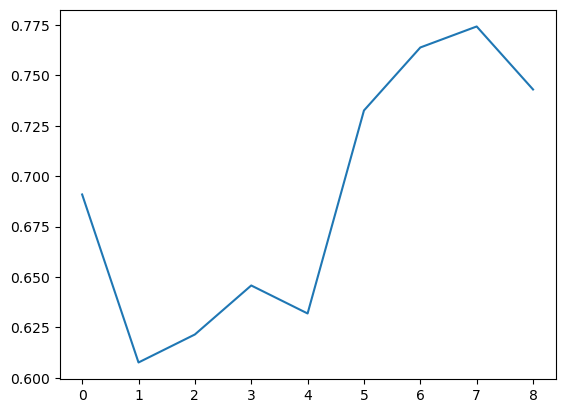

In [151]:
f1 = []
for i in [3, 6, 9, 12, 15, 18, 21, 24, 27]:
    clf = AdaBoost(number_of_stumps=i)
    clf.fit(data=train, label_col="positive")
    y_pred: npt.NDArray[np.int8] =  clf.predict(X=X_test)
    r = get_run_info(y_pred=y_pred, y_test=y_test)
    f1.append(r["accuracy_score"])
sns.lineplot(f1)